We now demonstrate how we can interpret weights in the dot product model.

We first reproduce our work up to training the model.

In [1]:
from fastai.collab import *
from fastai.tabular.all import *

# Architecture definition
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:, 0]) + self.movie_bias(x[:, 1])
        return sigmoid_range(res, *self.y_range)


In [2]:
# Dataset preparation
path = untar_data(URLs.ML_100k)

ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user_id', 'movie_id', 'rating', 'timestamp'])
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0, 1), names=('movie_id', 'title'), header=None)
ratings = ratings.merge(movies)
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

n_users  = len(dls.classes['user_id'])
n_movies = len(dls.classes['title'])
n_factors = 5


In [3]:
# Model instantiation and training
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.882804,0.962565,00:06
1,0.643562,0.899256,00:06
2,0.523071,0.886316,00:07
3,0.447741,0.866637,00:07
4,0.447787,0.863765,00:06


The general reception of each movie across individual preferences can be thought to be encoded in their corresponding bias weight. With an aim to retrieve the most and least liked movies, we first perform some manipulation to extract the weights. The lower the bias weight, the less well-liked.

Here, `squeeze` munges out dimensions of size `1` from the tensor.

In [4]:
movie_bias = learn.model.movie_bias.weight.squeeze()
bottom_idxs = movie_bias.argsort()[:5]
top_idxs = movie_bias.argsort(descending=True)[:5]
(top_idxs, bottom_idxs)

(tensor([1318, 1399, 1501,  613,   93], device='cuda:0'),
 tensor([ 295, 1001,  177,  140,  800], device='cuda:0'))

The `DataLoaders` has numericalized the `title`s of the dataset before passing it to the model, so we shall ask it to perform the reverse mapping for our comprehension. See the second notebook, and recall `dls.classes`.

In [5]:
dls.classes

{'user_id': ['#na#', np.int16(1), np.int16(2), np.int16(3), np.int16(4), np.int16(5), np.int16(6), np.int16(7), np.int16(8), np.int16(9), np.int16(10), np.int16(11), np.int16(12), np.int16(13), np.int16(14), np.int16(15), np.int16(16), np.int16(17), np.int16(18), np.int16(19), np.int16(20), np.int16(21), np.int16(22), np.int16(23), np.int16(24), np.int16(25), np.int16(26), np.int16(27), np.int16(28), np.int16(29), np.int16(30), np.int16(31), np.int16(32), np.int16(33), np.int16(34), np.int16(35), np.int16(36), np.int16(37), np.int16(38), np.int16(39), np.int16(40), np.int16(41), np.int16(42), np.int16(43), np.int16(44), np.int16(45), np.int16(46), np.int16(47), np.int16(48), np.int16(49), np.int16(50), np.int16(51), np.int16(52), np.int16(53), np.int16(54), np.int16(55), np.int16(56), np.int16(57), np.int16(58), np.int16(59), np.int16(60), np.int16(61), np.int16(62), np.int16(63), np.int16(64), np.int16(65), np.int16(66), np.int16(67), np.int16(68), np.int16(69), np.int16(70), np.int16

In [6]:
[ [ dls.classes['title'][i] for i in idxs ] for idxs in [top_idxs, bottom_idxs] ]

[['Shawshank Redemption, The (1994)',
  'Star Wars (1977)',
  'Titanic (1997)',
  'Godfather, The (1972)',
  'Apt Pupil (1998)'],
 ['Children of the Corn: The Gathering (1996)',
  'Mortal Kombat: Annihilation (1997)',
  'Bio-Dome (1996)',
  'Beautician and the Beast, The (1997)',
  'Jury Duty (1995)']]

Next, the thematic and genre qualities of movies, wrt the idiosyncracies of users, can be thought to be encoded in their latent factors. 

Due to regularization, we can consider the weights to be of comparable significance wrt their numeric magnitude; for example, we shall not have a factor where, say, the user factor values have high variance and the movie factor values have low variance for no good reason, and they cancel out in the multiplication, since the weight decay will penalize that out.

Under this assumption, PCA is meaningful for organizing variation.

We make a further assumption: it is meaningful to consider the most dominating ways in which the movies vary. To give an very imperfect illustration, assuming that movies are either comedy or tragedy and that it is a dominating way, we are assuming that few people who like comedies like tragedies and vice versa, and furthermore, that all other ways identified in which we can categorize movies are much less potent as comedy/tragedy at predicting whether a user (who likes one extreme of said category) would like a given movie.

Then PCA orders the weights by how dominating they are, and below we consider the two most dominating ways among the first 1000 movies ordered by how many times they have been rated, and plot them below.

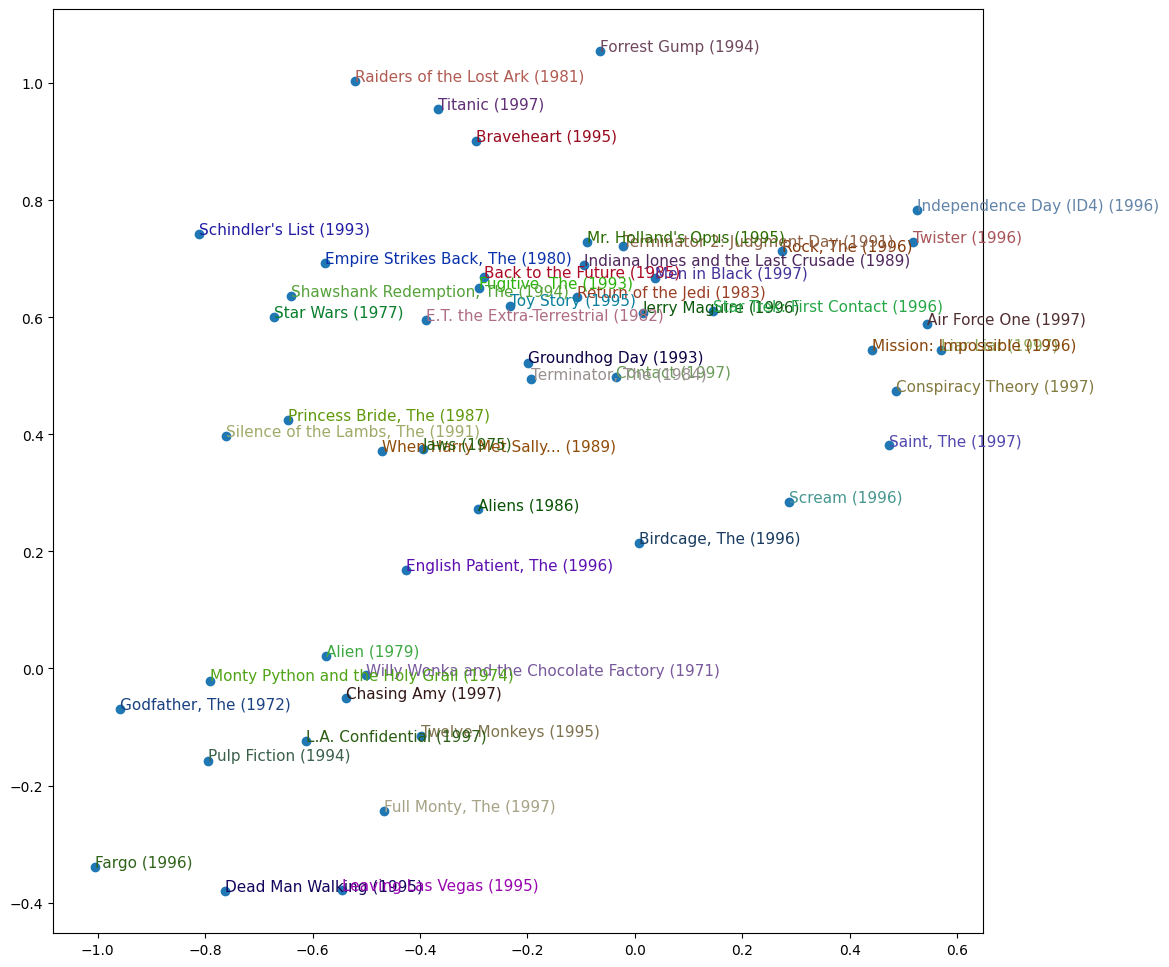

In [7]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors.weight[top_idxs].cpu().detach()
movie_pca = movie_w.pca(2)
[fac0, fac1] = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(12, 12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x, y, i, color=np.random.rand(3) * 0.7, fontsize=11)
plt.show()
